# BTC Predictor

In [69]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [70]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *

PATH='data/stock/'

## Create datasets

You can download the datasets used [here](https://www.kaggle.com/c/titanic/data).

Feature Space:
* train: Training set provided by competition
* test: testing set

In [71]:
table_names = ['btc-bitstamp-2012-01-01_to_2018-01-08']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [72]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [73]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains Passenger info such as Gender, Age, Ticket, Fare and whether Survived, the prediction variable
* test: Same as training table, w/o Survived


In [74]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


The following returns summarized aggregate information to each table accross each field.

In [75]:
# for t in tables: display(DataFrameSummary(t).summary())

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [76]:
train= tables[0]

In [77]:
len(train)

3161057

Time modifications

In [78]:
#convert to date objects
train["Timestamp"] = pd.to_datetime(train["Timestamp"], unit='s')
train['hour'] = train.Timestamp.dt.hour;
train['minute'] = train.Timestamp.dt.minute;
train.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,hour,minute
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,52
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,53
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,54
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,55
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,56


SET DEPENDENT VARIABLE ACTION

In [79]:
lookahead = 120
percentIncrease = 1.005
train['action'] =  train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close']

# train['action'] = 0;
# train.loc[train['Close'].rolling(window=lookahead).max() > train['Close'], 'action'] = 1
# train.loc[train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close'], 'action'] = 2

train.action = train.action.astype(int)

# target count by category
len(train[train.action==2]),len(train[train.action==1]),len(train[train.action==0])

(0, 1244058, 1916999)

In [80]:
# edit columns
train["VolumeBTC"] = train["Volume_(BTC)"]
train.drop('Volume_(BTC)',1,inplace=True)
train["VolumeCurrency"] = train["Volume_(Currency)"]
train.drop('Volume_(Currency)',1,inplace=True)
train["WeightedPrice"] = train["Weighted_Price"]
train.drop('Weighted_Price',1,inplace=True)

# delete unused columns
train.drop('VolumeCurrency',1,inplace=True)
train.head()

,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,WeightedPrice
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,7,52,0,0.455581,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,7,53,0,0.455581,4.39
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,7,54,0,0.455581,4.39
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,7,55,0,0.455581,4.39
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,7,56,0,0.455581,4.39


In [81]:
# trim to x records for now
# TODO: remove this
train = train.tail(110000)
len(train)

110000

In [82]:
# remove all 0 values 
train = train[train.Open!=0]
train = train[train.High!=0]
train = train[train.Low!=0]
train = train[train.Close!=0]
train = train[train.WeightedPrice!=0]
train = train[train.VolumeBTC!=0]
len(train)

110000

In [83]:
# add technical analysis
# train = add_all_ta_features(train, "Open", "High", "Low", "Close", "VolumeBTC", fillna=False)

In [84]:
# add all date time values
add_datepart(train, "Timestamp", drop=False)

Create test set

In [85]:
# todo: make this into a percentage instead of hardcoding the test set
test = train.tail(10000)
test.reset_index(inplace=True)
train = train.head(100000)
train.reset_index(inplace=True)
len(train),len(test)

(100000, 10000)

In [86]:
train.to_feather(f'{PATH}train')
test.to_feather(f'{PATH}test')

## Create features

In [87]:
train = pd.read_feather(f'{PATH}train')
test = pd.read_feather(f'{PATH}test')

In [88]:
train.tail(30).T.head(70)

,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
index,3151027,3151028,3151029,3151030,3151031,3151032,3151033,3151034,3151035,3151036,...,3151047,3151048,3151049,3151050,3151051,3151052,3151053,3151054,3151055,3151056
Timestamp,2018-01-01 00:51:00,2018-01-01 00:52:00,2018-01-01 00:53:00,2018-01-01 00:54:00,2018-01-01 00:55:00,2018-01-01 00:56:00,2018-01-01 00:57:00,2018-01-01 00:58:00,2018-01-01 00:59:00,2018-01-01 01:00:00,...,2018-01-01 01:11:00,2018-01-01 01:12:00,2018-01-01 01:13:00,2018-01-01 01:14:00,2018-01-01 01:15:00,2018-01-01 01:16:00,2018-01-01 01:17:00,2018-01-01 01:18:00,2018-01-01 01:19:00,2018-01-01 01:20:00
Open,13662.4,13732.8,13704.5,13693.6,13668.5,13622,13601,13628.5,13633.6,13635.1,...,13567,13614,13600,13600,13600,13567.8,13597,13643.9,13642.9,13675.2
High,13733.9,13733.1,13704.5,13693.6,13668.5,13630,13630,13651.9,13668.5,13681.4,...,13614,13614.1,13600,13600,13600,13599,13647,13643.9,13675.3,13694.1
Low,13662.4,13669.6,13668.5,13690.8,13622,13600.3,13601,13601,13633.6,13635.1,...,13564.1,13585.3,13565.7,13600,13565.2,13564.1,13576.3,13604.7,13605,13647.5
Close,13710,13669.6,13704.5,13690.8,13622,13630,13623.4,13651.8,13668.5,13681.4,...,13614,13614.1,13600,13600,13599,13597,13645,13618.5,13647.5,13694.1
hour,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
minute,51,52,53,54,55,56,57,58,59,0,...,11,12,13,14,15,16,17,18,19,20
action,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
VolumeBTC,1.15904,1.27812,0.109093,0.0459614,13.2409,1.02044,0.19926,2.3952,1.49931,0.531898,...,1.03008,1.24946,0.272052,0.0454431,0.384441,0.885178,4.08005,0.283713,12.4654,18.4473


In [89]:
# display(DataFrameSummary(train).summary())

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [90]:
train.head()

,index,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,...,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed
0,3051057,2017-10-23 14:41:00,5745.0,5745.0,5738.00,5738.0,14,41,1,6.247508,...,23,0,296,False,False,False,False,False,False,1508769660
1,3051058,2017-10-23 14:42:00,5738.0,5745.0,5738.00,5745.0,14,42,1,10.207588,...,23,0,296,False,False,False,False,False,False,1508769720
2,3051059,2017-10-23 14:43:00,5745.0,5745.0,5739.03,5745.0,14,43,1,0.602053,...,23,0,296,False,False,False,False,False,False,1508769780
3,3051060,2017-10-23 14:44:00,5745.0,5745.0,5713.90,5725.0,14,44,1,7.036934,...,23,0,296,False,False,False,False,False,False,1508769840
4,3051061,2017-10-23 14:45:00,5725.0,5725.0,5690.00,5690.0,14,45,1,112.226667,...,23,0,296,False,False,False,False,False,False,1508769900


Identify categorical vs continuous variables.  PassengerId serves as the unique identifier for each row.

In [91]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek', 'TimestampDayofyear', 
'TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end', 'TimestampIs_quarter_start', 
'TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'VolumeBTC', 'WeightedPrice', 'TimestampElapsed']
# ,'volume_adi','volume_obv','momentum_rsi'

index='Timestamp'
dep = 'action'
n = len(train); n

test = test.set_index(index)
train = train.set_index(index)
   

In [92]:
train = train[cat_vars+contin_vars+[dep]].copy()
# , index

In [93]:
# test[dep] = 0 
test = test[cat_vars+contin_vars+[dep]].copy()
# , index


In [94]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [95]:
apply_cats(test, train)
# test

In [96]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

We can now process our data...

In [97]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)

In [98]:
y.shape


(100000,)

In [99]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)
# train.head(40).T.head(70)
train

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,...,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed,action
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-23 14:41:00,2017,10,43,23,14,41,0,296,False,False,...,False,False,5745.000000,5738.000000,5745.000000,5738.000000,6.247508,5739.839355,1.508770e+09,1
2017-10-23 14:42:00,2017,10,43,23,14,42,0,296,False,False,...,False,False,5738.000000,5745.000000,5745.000000,5738.000000,10.207588,5738.308594,1.508770e+09,1
2017-10-23 14:43:00,2017,10,43,23,14,43,0,296,False,False,...,False,False,5745.000000,5745.000000,5745.000000,5739.029785,0.602053,5744.901367,1.508770e+09,1
2017-10-23 14:44:00,2017,10,43,23,14,44,0,296,False,False,...,False,False,5745.000000,5725.000000,5745.000000,5713.899902,7.036933,5726.313965,1.508770e+09,1
2017-10-23 14:45:00,2017,10,43,23,14,45,0,296,False,False,...,False,False,5725.000000,5690.000000,5725.000000,5690.000000,112.226669,5705.793457,1.508770e+09,1
2017-10-23 14:46:00,2017,10,43,23,14,46,0,296,False,False,...,False,False,5690.000000,5682.459961,5700.000000,5682.459961,34.368427,5692.196289,1.508770e+09,1
2017-10-23 14:47:00,2017,10,43,23,14,47,0,296,False,False,...,False,False,5681.790039,5655.009766,5681.790039,5650.000000,95.952698,5670.854492,1.508770e+09,1
2017-10-23 14:48:00,2017,10,43,23,14,48,0,296,False,False,...,False,False,5659.799805,5657.439941,5659.799805,5650.000000,13.429200,5650.926758,1.508770e+09,1
2017-10-23 14:49:00,2017,10,43,23,14,49,0,296,False,False,...,False,False,5657.439941,5674.049805,5674.060059,5657.439941,12.021286,5671.571289,1.508770e+09,1


In [100]:
nas={}

In [101]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,...,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-23 14:41:00,1,2,2,23,15,42,1,2,1,1,...,1,1,1,-1.191094,-1.192702,-1.192,-1.191729,-0.262773,-1.192191,-1.732014
2017-10-23 14:42:00,1,2,2,23,15,43,1,2,1,1,...,1,1,1,-1.192778,-1.191018,-1.192,-1.191729,-0.066790,-1.192559,-1.732014


In [102]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,...,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:21:00,2,1,1,1,2,22,1,1,1,2,...,2,1,2,0.721740,0.721784,0.717234,0.727470,-0.562929,0.722237,1.732088
2018-01-01 01:22:00,2,1,1,1,2,23,1,1,1,2,...,2,1,2,0.721748,0.723986,0.719710,0.719732,-0.552069,0.720471,1.732088


Rake the last x% of rows as our validation set.

In [103]:
train_ratio = 0.9
train_size = int(n * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [104]:
len(val_idx)

10000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [105]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [106]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [107]:
cat_sz

[('TimestampYear', 3),
 ('TimestampMonth', 5),
 ('TimestampWeek', 12),
 ('TimestampDay', 32),
 ('hour', 25),
 ('minute', 61),
 ('TimestampDayofweek', 8),
 ('TimestampDayofyear', 72),
 ('TimestampIs_month_end', 3),
 ('TimestampIs_month_start', 3),
 ('TimestampIs_quarter_end', 3),
 ('TimestampIs_quarter_start', 3),
 ('TimestampIs_year_end', 3),
 ('TimestampIs_year_start', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [108]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [109]:
emb_szs

[(3, 2),
 (5, 3),
 (12, 6),
 (32, 16),
 (25, 13),
 (61, 31),
 (8, 4),
 (72, 36),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

Check if cuda is available

In [110]:
torch.cuda.is_available()

True

In [111]:
len(df.columns)-len(cat_vars)

7

In [112]:
dropout = 0.06
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)

In [113]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(5, 3)
    (2): Embedding(12, 6)
    (3): Embedding(32, 16)
    (4): Embedding(25, 13)
    (5): Embedding(61, 31)
    (6): Embedding(8, 4)
    (7): Embedding(72, 36)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=130, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True)
)

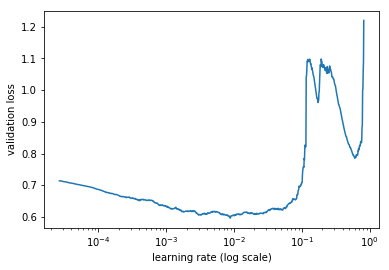

In [114]:
m.lr_find()
m.sched.plot(100)
lr = 1e-5

In [115]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.667907   0.614714  
    1      0.653462   0.563058                                  
    2      0.650295   0.550145                                  


[array([0.55014])]

In [116]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.642179   0.548152  
    1      0.644323   0.545898                                  
    2      0.64163    0.544862                                  
    3      0.636779   0.544618                                  
    4      0.631587   0.544423                                  


[array([0.54442])]

In [117]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.626983   0.544964  
    1      0.620421   0.548084                                  
    2      0.615392   0.548414                                  
    3      0.610023   0.548435                                  
    4      0.609439   0.549721                                  
    5      0.607363   0.553196                                  
    6      0.607898   0.552246                                  
    7      0.602535   0.552065                                  
    8      0.601783   0.55166                                   
    9      0.606859   0.552228                                  
    10     0.608489   0.55228                                   
    11     0.599272   0.552244                                  
    12     0.602606   0.553683                                  
    13     0.600001   0.552414                                  
    14     0.599994   0.551516                           

[array([0.54929])]

In [118]:
m.save('btcBinaryClassificationModel')

In [119]:
m.load('btcBinaryClassificationModel')

## Validation

In [158]:
def calculateAccuracy(valpred):
    successfulPredictions = valpred.loc[valpred.action == valpred.predicted]
    # total accuracy does not provide an accurate represantation
    # totalAccuracy = len(successfulPredictions)/len(valpred)
    totalBuyActions = valpred.loc[valpred.action == 1]
    totalSellActions = valpred.loc[valpred.action == 0]
    successfulBuyPredictions = successfulPredictions.loc[successfulPredictions.action == 1]
    successfulSellPredictions = successfulPredictions.loc[successfulPredictions.action == 0]
    buyAccuracy = len(successfulBuyPredictions)/len(totalBuyActions)
    sellAccuracy = len(successfulSellPredictions)/len(totalSellActions)
    result = {
        'F1Score': (buyAccuracy + sellAccuracy )/2,
        'buyAccuracy': buyAccuracy,
        'sellAccuracy': sellAccuracy,
        'totalBuyActions': len(totalBuyActions),
        'successfulBuyPredictions': len(successfulBuyPredictions)
    }
    return result


In [120]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [121]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

In [122]:
y1.shape


(10000,)

In [123]:
val = train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({'Close':val.Close,'index':val.index, 'action':val.action, 'predicted':np.argmax(x,axis=1)})[['Close','index', 'action','predicted']]
valpred.head(10)

,Close,index,action,predicted
Timestamp,,,,
2017-12-25 02:41:00,13559.110352,2017-12-25 02:41:00,1,1
2017-12-25 02:42:00,13513.709961,2017-12-25 02:42:00,1,1
2017-12-25 02:43:00,13501.219727,2017-12-25 02:43:00,1,1
2017-12-25 02:44:00,13502.000000,2017-12-25 02:44:00,1,1
2017-12-25 02:45:00,13500.000000,2017-12-25 02:45:00,1,1
2017-12-25 02:46:00,13496.480469,2017-12-25 02:46:00,1,1
2017-12-25 02:47:00,13430.000000,2017-12-25 02:47:00,1,1
2017-12-25 02:48:00,13506.990234,2017-12-25 02:48:00,1,1
2017-12-25 02:49:00,13551.030273,2017-12-25 02:49:00,1,1


Calculate the percent accuracy on the validation set

In [159]:
calculateAccuracy(valpred)

{'F1Score': 0.49995883034172384,
 'buyAccuracy': 0.9953836556456643,
 'sellAccuracy': 0.004534005037783375,
 'totalBuyActions': 8015,
 'successfulBuyPredictions': 7978}

## Test

In [125]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [126]:
testPred = pd.DataFrame({'Timestamp':test.index, 'Close':test.Close, 'action':test.action, 'predicted':np.argmax(m.predict(True), axis =1)})[['Close','Timestamp', 'action', 'predicted']]
testPred.head(10)

,Close,Timestamp,action,predicted
Timestamp,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,1,1
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,1,1
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,1,1
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1


Calculate the percent accuracy on the test set

In [160]:
calculateAccuracy(testPred)

{'F1Score': 0.494366734220077,
 'buyAccuracy': 0.6701710120549481,
 'sellAccuracy': 0.31856245638520586,
 'totalBuyActions': 7134,
 'successfulBuyPredictions': 4781}

In [128]:
# csv_fn=f'{PATH}/tmp/sub4.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

## Random Forest

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [131]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [132]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

Accuracy on the validation set using a Random Forest Regressor

In [133]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

(0.9795630904403988, -0.5923611867952148, 0.9169965382032647, 0.5643)

In [134]:
preds_test = m.predict(df_test.values)

In [135]:
sub = pd.DataFrame({'Timestamp':test.index, 'action':PredtoClass(preds_test)})[['Timestamp', 'action']]
sub.head(10)

,Timestamp,action
0,2018-01-01 01:21:00,1
1,2018-01-01 01:22:00,1
2,2018-01-01 01:23:00,1
3,2018-01-01 01:24:00,1
4,2018-01-01 01:25:00,1
5,2018-01-01 01:26:00,1
6,2018-01-01 01:27:00,1
7,2018-01-01 01:28:00,1
8,2018-01-01 01:29:00,1
9,2018-01-01 01:30:00,1


In [136]:
# csv_fn=f'{PATH}/tmp/RFsub5.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)